# Lecture 21 – Data 100, Spring 2025

Data 100, Spring 2025

[Acknowledgments Page](https://ds100.org/sp25/acks/)

### Loading the Data
In this lecture, we'll continue our work with the `Dish` table. In the cells below, we connect to the database and query the table.

In [ ]:
%load_ext sql

In [ ]:
%config SqlMagic.displaylimit = 100

Loading the SQLite database file using duckdb.

In [ ]:
%sql duckdb:///data/basic_examples.db --alias duckdb

Get the large IMDB database file for other examples in this demo.

In [6]:
!pip install gdown

import os
if os.path.exists("/home/jovyan/shared/sql/imdb_duck.db"):
    imdbpath = "duckdb:////home/jovyan/shared/sql/imdb_duck.db"
elif os.path.exists("data/imdb_duck.db"):
    imdbpath =  "duckdb:///data/imdb_duck.db"
else:
    import gdown
    url = 'https://drive.google.com/uc?id=10tKOHGLt9QoOgq5Ii-FhxpB9lDSQgl1O'
    output_path = 'data/imdb_duck.db'
    gdown.download(url, output_path, quiet=False)
    imdbpath = "duckdb:///data/imdb_duck.db"
print(imdbpath)

duckdb:///data/imdb_duck.db


In [7]:
from sqlalchemy import create_engine
imdb_engine = create_engine(imdbpath, connect_args={'read_only': True})
imdb_engine = create_engine("duckdb:///data/imdb_duck.db", connect_args={'read_only': True})
%sql imdb_engine --alias imdb

## More on Basic Queries

### Ordering data using `ORDER BY`

In [8]:
%%sql duckdb
SELECT *
FROM Dragon
ORDER BY cute DESC;

Switching to connection 'duckdb'

+----------+------+------+
|   name   | year | cute |
+----------+------+------+
|   puff   | 2010 | 100  |
|  hiccup  | 2010 |  10  |
| dragon 2 | 2019 |  0   |
|  drogon  | 2011 | -100 |
|  smaug   | 2011 | None |
+----------+------+------+

### Restricting output with `LIMIT` and `OFFSET`

In [9]:
%%sql duckdb
SELECT *
FROM Dragon
LIMIT 2;

+--------+------+------+
|  name  | year | cute |
+--------+------+------+
| hiccup | 2010 |  10  |
| drogon | 2011 | -100 |
+--------+------+------+

In [10]:
%%sql duckdb
SELECT *
FROM Dragon
LIMIT 2
OFFSET 1;

+----------+------+------+
|   name   | year | cute |
+----------+------+------+
|  drogon  | 2011 | -100 |
| dragon 2 | 2019 |  0   |
+----------+------+------+

## Sampling from a Database

What if we wanted a random sample:

In [11]:
%%sql duckdb
SELECT *
FROM Dragon
ORDER BY RANDOM() 
LIMIT 2

+-------+------+------+
|  name | year | cute |
+-------+------+------+
|  puff | 2010 | 100  |
| smaug | 2011 | None |
+-------+------+------+

In [12]:
%%sql duckdb
SELECT * 
FROM Dragon USING SAMPLE reservoir(2 ROWS) REPEATABLE (100);

+--------+------+------+
|  name  | year | cute |
+--------+------+------+
|  puff  | 2010 | 100  |
| drogon | 2011 | -100 |
+--------+------+------+

## Grouping Data with `GROUP BY`

In [13]:
%%sql duckdb
SELECT *
FROM Dish;

+------------+-----------+------+
|    name    |    type   | cost |
+------------+-----------+------+
|  ravioli   |   entree  |  10  |
|   ramen    |   entree  |  13  |
|    taco    |   entree  |  7   |
|  edamame   | appetizer |  4   |
|   fries    | appetizer |  4   |
| potsticker | appetizer |  4   |
| ice cream  |  dessert  |  5   |
+------------+-----------+------+

In [14]:
%%sql duckdb
SELECT type
FROM Dish;

+-----------+
|    type   |
+-----------+
|   entree  |
|   entree  |
|   entree  |
| appetizer |
| appetizer |
| appetizer |
|  dessert  |
+-----------+

In [15]:
%%sql duckdb
SELECT type
FROM Dish
GROUP BY type;

+-----------+
|    type   |
+-----------+
|   entree  |
|  dessert  |
| appetizer |
+-----------+

In [16]:
%%sql duckdb
SELECT type, SUM(cost)
FROM Dish
GROUP BY type;

+-----------+-------------+
|    type   | sum("cost") |
+-----------+-------------+
| appetizer |      12     |
|   entree  |      30     |
|  dessert  |      5      |
+-----------+-------------+

In [17]:
%%sql duckdb
SELECT type, 
       SUM(cost), 
       MIN(cost),
       MAX(name)
FROM Dish
GROUP BY type;

+-----------+-------------+-------------+-------------+
|    type   | sum("cost") | min("cost") | max("name") |
+-----------+-------------+-------------+-------------+
|   entree  |      30     |      7      |     taco    |
|  dessert  |      5      |      5      |  ice cream  |
| appetizer |      12     |      4      |  potsticker |
+-----------+-------------+-------------+-------------+

In [18]:
%%sql duckdb
SELECT year, COUNT(cute)
FROM Dragon
GROUP BY year;

+------+-------------+
| year | count(cute) |
+------+-------------+
| 2010 |      2      |
| 2011 |      1      |
| 2019 |      1      |
+------+-------------+

In [19]:
%%sql duckdb
SELECT year, COUNT(*)
FROM Dragon
GROUP BY year;

+------+--------------+
| year | count_star() |
+------+--------------+
| 2010 |      2       |
| 2011 |      2       |
| 2019 |      1       |
+------+--------------+

## Filtering Groups Using `HAVING`

In [20]:
%%sql duckdb
    
SELECT *
FROM Dish;

+------------+-----------+------+
|    name    |    type   | cost |
+------------+-----------+------+
|  ravioli   |   entree  |  10  |
|   ramen    |   entree  |  13  |
|    taco    |   entree  |  7   |
|  edamame   | appetizer |  4   |
|   fries    | appetizer |  4   |
| potsticker | appetizer |  4   |
| ice cream  |  dessert  |  5   |
+------------+-----------+------+

In [21]:
%%sql duckdb
    
SELECT type, COUNT(*)
FROM Dish
GROUP BY type
HAVING MAX(cost) < 10;

+-----------+--------------+
|    type   | count_star() |
+-----------+--------------+
| appetizer |      3       |
|  dessert  |      1       |
+-----------+--------------+

In [22]:
%%sql duckdb
    
SELECT type, COUNT(*)
FROM Dish
WHERE cost < 10
GROUP BY type

+-----------+--------------+
|    type   | count_star() |
+-----------+--------------+
|   entree  |      1       |
|  dessert  |      1       |
| appetizer |      3       |
+-----------+--------------+

In [23]:
%%sql
SELECT * FROM Dragon

Running query in 'duckdb'

+----------+------+------+
|   name   | year | cute |
+----------+------+------+
|  hiccup  | 2010 |  10  |
|  drogon  | 2011 | -100 |
| dragon 2 | 2019 |  0   |
|   puff   | 2010 | 100  |
|  smaug   | 2011 | None |
+----------+------+------+

In [24]:
%%sql duckdb
    
SELECT year, MAX(cute)
FROM Dragon
WHERE name in ('hiccup', 'dragon', 'puff')
GROUP BY year
HAVING MIN(cute) >= 0;

+------+-----------+
| year | max(cute) |
+------+-----------+
| 2010 |    100    |
+------+-----------+

## EDA in SQL

Our typical workflow when working with "big data" is:
* Use SQL to query data from a database
* Use Python (with `pandas`) to analyze this data in detail

We can, however, still perform simple data cleaning and re-structuring using SQL directly. To do so, we'll consider the `Title` table from the IMDB dataset.

In [25]:
%%sql imdb
SELECT setseed(0.42); -- Setting the random number seed

SELECT *
FROM Title
ORDER BY RANDOM()
LIMIT 10;

Switching to connection 'imdb'

+------------+-----------+---------------------------------------------+---------------------------------------------+---------+-----------+---------+----------------+------------------------+
|   tconst   | titleType |                 primaryTitle                |                 originaTitle                | isAdult | startYear | endYear | runtimeMinutes |         genres         |
+------------+-----------+---------------------------------------------+---------------------------------------------+---------+-----------+---------+----------------+------------------------+
| tt2215274  |  tvMovie  |            Tony Bennett: Duets II           |            Tony Bennett: Duets II           |  False  |    2012   |   None  |       86       |         Music          |
| tt26412602 |   movie   |                 White River                 |                   Yan Jiao                  |  False  |    2023   |   None  |       91       |         Drama          |
| tt1316064  |   movie   |                Made in China                |                Made in China                |  False  |    2009   |   None  |       87       |         Comedy         |
| tt0288008  |   movie   |                Fini Henriques               |                Fini Henriques               |  False  |    1929   |   None  |      None      |      Documentary       |
| tt4963886  |   movie   |                  Cage Kings                 |                  Cage Kings                 |  False  |    None   |   None  |      None      |         Action         |
| tt30460534 |   movie   |     Return to the Dark House of Mystery     |     Return to the Dark House of Mystery     |  False  |    None   |   None  |       60       |         Horror         |
| tt1195480  |  tvMovie  |  George Beverly Shea: The Wonder of it All  |  George Beverly Shea: The Wonder of it All  |  False  |    1999   |   None  |       60       |       Biography        |
| tt21045886 |  tvMovie  | Medical Examiner Dr. Qin: Blood Red Wedding | Medical Examiner Dr. Qin: Blood Red Wedding |  False  |    2019   |   None  |      None      |         Crime          |
| tt8506910  |   movie   |                Twisted Games                |                Twisted Games                |  False  |    None   |   None  |      None      |         Horror         |
| tt0251270  |   movie   |          A Midsummer Night's Dream          |          A Midsummer Night's Dream          |  False  |    1968   |   None  |      124       | Comedy,Fantasy,Romance |
+------------+-----------+---------------------------------------------+---------------------------------------------+---------+-----------+---------+----------------+------------------------+

### Matching Text Using `LIKE`

In [26]:
%%sql imdb 
    
SELECT titleType, primaryTitle
FROM Title
WHERE primaryTitle LIKE '%Star Wars%'

+-----------+--------------------------------------------------------------------------------------------+
| titleType |                                        primaryTitle                                        |
+-----------+--------------------------------------------------------------------------------------------+
|   movie   |                             Star Wars: Episode IV - A New Hope                             |
|   movie   |                       Star Wars: Episode V - The Empire Strikes Back                       |
|   movie   |                         Star Wars: Episode VI - Return of the Jedi                         |
|   movie   |                         Star Wars: Episode I - The Phantom Menace                          |
|   movie   |                        Star Wars: Episode II - Attack of the Clones                        |
|   movie   |                        Star Wars: Episode III - Revenge of the Sith                        |
|  tvMovie  |                               The Star Wars Holiday Special                                |
|  tvMovie  |             From Star Wars to Star Wars: The Story of Industrial Light & Magic             |
|  tvMovie  |                                       Star Wars City                                       |
|  tvMovie  |                      From 'Star Wars' to 'Jedi': The Making of a Saga                      |
|  tvMovie  |                                 The Making of 'Star Wars'                                  |
|   movie   |                            Doraemon: Nobita's Little Star Wars                             |
|   movie   |                                      Saving Star Wars                                      |
|  tvMovie  |                                 The Mythology of Star Wars                                 |
|  tvMovie  |                                 Star Wars: Feel the Force                                  |
|   movie   |                            The Untitled Star Wars Mockumentary                             |
|  tvMovie  |                             Star Wars: The Magic & the Mystery                             |
|  tvMovie  |                                   Star Wars: Shortened!                                    |
|  tvMovie  |                               When Star Wars Ruled the World                               |
|  tvMovie  |                                  Robot Chicken: Star Wars                                  |
|   movie   |                            Star Wars: Battle for the Holocrons                             |
|   movie   |                          Rifftrax: The Star Wars Holiday Special                           |
|   movie   |                                 Star Wars: Rogue Squadron                                  |
|   movie   |                           Untitled Taika Waititi Star Wars Film                            |
|   movie   |                                 Star Wars: New Jedi Order                                  |
|   movie   |                           RiffTrax: Star Wars: The Force Awakens                           |
|  tvMovie  |                               Star Wars: The Legacy Revealed                               |
|  tvMovie  |                                       Star Wars Tech                                       |
|  tvMovie  |                                  Bring Back... Star Wars                                   |
|  tvMovie  |                      Nissan Rogue: Star Wars Rogue One Battle Tested                       |
|  tvMovie  |                           Walmart: Rogue One: A Star Wars Story                            |
|  tvMovie  | John Boyega Pranks Star Wars Fans with Surprise Photobomb at Celebration: Force For Change |
|  tvMovie  |                         Star Wars Galaxy's Edge: Adventure Awaits                          |
|   movie   |                                      77-Star Wars-17                                       |
|   movie   |                           U

In [27]:
%%sql imdb 
    
SELECT titleType, primaryTitle
FROM Title
WHERE primaryTitle SIMILAR TO '.*Star Wars.*'

+-----------+--------------------------------------------------------------------------------------------+
| titleType |                                        primaryTitle                                        |
+-----------+--------------------------------------------------------------------------------------------+
|   movie   |                             Star Wars: Episode IV - A New Hope                             |
|   movie   |                       Star Wars: Episode V - The Empire Strikes Back                       |
|   movie   |                         Star Wars: Episode VI - Return of the Jedi                         |
|   movie   |                         Star Wars: Episode I - The Phantom Menace                          |
|   movie   |                        Star Wars: Episode II - Attack of the Clones                        |
|   movie   |                        Star Wars: Episode III - Revenge of the Sith                        |
|  tvMovie  |                               The Star Wars Holiday Special                                |
|  tvMovie  |             From Star Wars to Star Wars: The Story of Industrial Light & Magic             |
|  tvMovie  |                                       Star Wars City                                       |
|  tvMovie  |                      From 'Star Wars' to 'Jedi': The Making of a Saga                      |
|  tvMovie  |                                 The Making of 'Star Wars'                                  |
|   movie   |                            Doraemon: Nobita's Little Star Wars                             |
|   movie   |                                      Saving Star Wars                                      |
|  tvMovie  |                                 The Mythology of Star Wars                                 |
|  tvMovie  |                                 Star Wars: Feel the Force                                  |
|   movie   |                            The Untitled Star Wars Mockumentary                             |
|  tvMovie  |                             Star Wars: The Magic & the Mystery                             |
|  tvMovie  |                                   Star Wars: Shortened!                                    |
|  tvMovie  |                               When Star Wars Ruled the World                               |
|  tvMovie  |                                  Robot Chicken: Star Wars                                  |
|   movie   |                            Star Wars: Battle for the Holocrons                             |
|   movie   |                          Rifftrax: The Star Wars Holiday Special                           |
|   movie   |                                 Star Wars: Rogue Squadron                                  |
|   movie   |                           Untitled Taika Waititi Star Wars Film                            |
|   movie   |                                 Star Wars: New Jedi Order                                  |
|   movie   |                           RiffTrax: Star Wars: The Force Awakens                           |
|  tvMovie  |                               Star Wars: The Legacy Revealed                               |
|  tvMovie  |                                       Star Wars Tech                                       |
|  tvMovie  |                                  Bring Back... Star Wars                                   |
|  tvMovie  |                      Nissan Rogue: Star Wars Rogue One Battle Tested                       |
|  tvMovie  |                           Walmart: Rogue One: A Star Wars Story                            |
|  tvMovie  | John Boyega Pranks Star Wars Fans with Surprise Photobomb at Celebration: Force For Change |
|  tvMovie  |                         Star Wars Galaxy's Edge: Adventure Awaits                          |
|   movie   |                                      77-Star Wars-17                                       |
|   movie   |                           U

In [28]:
%%sql imdb
    
SELECT titleType, primaryTitle
FROM Title
WHERE primaryTitle LIKE 'Harry Potter and the Deathly Hallows: Part _'

+-----------+----------------------------------------------+
| titleType |                 primaryTitle                 |
+-----------+----------------------------------------------+
|   movie   | Harry Potter and the Deathly Hallows: Part 1 |
|   movie   | Harry Potter and the Deathly Hallows: Part 2 |
+-----------+----------------------------------------------+

### Converting Data Types Using `CAST`

In [29]:
%%sql imdb
    
SELECT primaryTitle, CAST(runtimeMinutes AS FLOAT)
FROM Title
LIMIT 10;

+--------------------------------+-------------------------------+
|          primaryTitle          | CAST(runtimeMinutes AS FLOAT) |
+--------------------------------+-------------------------------+
|           Miss Jerry           |              45.0             |
| The Corbett-Fitzsimmons Fight  |             100.0             |
|            Bohemios            |             100.0             |
|  The Story of the Kelly Gang   |              70.0             |
|        The Prodigal Son        |              90.0             |
|       Robbery Under Arms       |              None             |
|             Hamlet             |              None             |
|          Don Quijote           |              None             |
| The Fairylogue and Radio-Plays |             120.0             |
|       A Cultura do Cacau       |              None             |
+--------------------------------+-------------------------------+

## Applying Conditions With `CASE`

Here, we return a random order so we can see the various movie ages (otherwise, the top few entries happen to all be old movies).

In [30]:
%%sql imdb

SELECT setseed(0.42); -- Setting the random number seed
    
SELECT titleType, startYear,
CASE WHEN startYear < '1950' THEN 'old'
     WHEN startYear < '2000' THEN 'mid-aged'
     ELSE 'new'
     END AS movie_age
FROM Title
ORDER BY RANDOM()
LIMIT 10;

+-----------+-----------+-----------+
| titleType | startYear | movie_age |
+-----------+-----------+-----------+
|  tvMovie  |    2012   |    new    |
|   movie   |    2023   |    new    |
|   movie   |    2009   |    new    |
|   movie   |    2007   |    new    |
|   movie   |    2005   |    new    |
|   movie   |    2016   |    new    |
|   movie   |    2024   |    new    |
|   movie   |    1929   |    old    |
|  tvMovie  |    2019   |    new    |
|   movie   |    2015   |    new    |
+-----------+-----------+-----------+

<br>

---


## Joining Tables

We combine data from multiple tables by performing a **join**. We will explore joins using the cats database, which includes two tables: `s` and `t`.

In [31]:
%sql duckdb:///data/cats.db --alias cats

Connecting and switching to connection 'cats'

In [32]:
%%sql cats

DROP TABLE IF EXISTS s;
DROP TABLE IF EXISTS t;

CREATE TABLE s (
    id INTEGER,
    name VARCHAR,
);

CREATE TABLE t (
    id INTEGER,
    breed VARCHAR
);


INSERT INTO s VALUES
(0, 'Apricot'),
(1, 'Boots'),
(2, 'Cally'),
(4, 'Eugene');

INSERT INTO t VALUES
(1, 'persian'),
(2, 'ragdoll'),
(4, 'bengal'),
(5, 'persian');

+-------+
| Count |
+-------+
+-------+

In [33]:
%%sql
SELECT * FROM t;

Running query in 'cats'

+----+---------+
| id |  breed  |
+----+---------+
| 1  | persian |
| 2  | ragdoll |
| 4  |  bengal |
| 5  | persian |
+----+---------+

### Inner Join

In [34]:
%%sql cats
SELECT s.id, name, breed
FROM s INNER JOIN t ON s.id = t.id;

+----+--------+---------+
| id |  name  |  breed  |
+----+--------+---------+
| 1  | Boots  | persian |
| 2  | Cally  | ragdoll |
| 4  | Eugene |  bengal |
+----+--------+---------+

By default, `JOIN`ing without specifying a join type will default to an inner join.

In [35]:
%%sql cats
SELECT s.id, name, breed
FROM s JOIN t ON s.id = t.id;

+----+--------+---------+
| id |  name  |  breed  |
+----+--------+---------+
| 1  | Boots  | persian |
| 2  | Cally  | ragdoll |
| 4  | Eugene |  bengal |
+----+--------+---------+

### Cross Join

In [36]:
%%sql cats
SELECT *
FROM s CROSS JOIN t;

+----+---------+------+---------+
| id |   name  | id_1 |  breed  |
+----+---------+------+---------+
| 0  | Apricot |  1   | persian |
| 0  | Apricot |  2   | ragdoll |
| 0  | Apricot |  4   |  bengal |
| 0  | Apricot |  5   | persian |
| 1  |  Boots  |  1   | persian |
| 1  |  Boots  |  2   | ragdoll |
| 1  |  Boots  |  4   |  bengal |
| 1  |  Boots  |  5   | persian |
| 2  |  Cally  |  1   | persian |
| 2  |  Cally  |  2   | ragdoll |
| 2  |  Cally  |  4   |  bengal |
| 2  |  Cally  |  5   | persian |
| 4  |  Eugene |  1   | persian |
| 4  |  Eugene |  2   | ragdoll |
| 4  |  Eugene |  4   |  bengal |
| 4  |  Eugene |  5   | persian |
+----+---------+------+---------+

Equivalently, a cross join can be performed using the following syntax:

In [37]:
%%sql cats
SELECT *
FROM s, t

+----+---------+------+---------+
| id |   name  | id_1 |  breed  |
+----+---------+------+---------+
| 0  | Apricot |  1   | persian |
| 0  | Apricot |  2   | ragdoll |
| 0  | Apricot |  4   |  bengal |
| 0  | Apricot |  5   | persian |
| 1  |  Boots  |  1   | persian |
| 1  |  Boots  |  2   | ragdoll |
| 1  |  Boots  |  4   |  bengal |
| 1  |  Boots  |  5   | persian |
| 2  |  Cally  |  1   | persian |
| 2  |  Cally  |  2   | ragdoll |
| 2  |  Cally  |  4   |  bengal |
| 2  |  Cally  |  5   | persian |
| 4  |  Eugene |  1   | persian |
| 4  |  Eugene |  2   | ragdoll |
| 4  |  Eugene |  4   |  bengal |
| 4  |  Eugene |  5   | persian |
+----+---------+------+---------+

Conceptually, an inner join is equivalent to a cross join where irrelevant rows are removed.

In [38]:
%%sql cats
    
SELECT *
FROM s CROSS JOIN t
WHERE s.id = t.id;

+----+--------+------+---------+
| id |  name  | id_1 |  breed  |
+----+--------+------+---------+
| 1  | Boots  |  1   | persian |
| 2  | Cally  |  2   | ragdoll |
| 4  | Eugene |  4   |  bengal |
+----+--------+------+---------+

### Left Outer Join

In [39]:
%%sql cats
    
SELECT *
FROM s LEFT JOIN t ON s.id = t.id;

+----+---------+------+---------+
| id |   name  | id_1 |  breed  |
+----+---------+------+---------+
| 1  |  Boots  |  1   | persian |
| 2  |  Cally  |  2   | ragdoll |
| 4  |  Eugene |  4   |  bengal |
| 0  | Apricot | None |   None  |
+----+---------+------+---------+

### Right Outer Join

In [40]:
%%sql cats
    
SELECT *
FROM s RIGHT JOIN t ON s.id = t.id;

+------+--------+------+---------+
|  id  |  name  | id_1 |  breed  |
+------+--------+------+---------+
|  1   | Boots  |  1   | persian |
|  2   | Cally  |  2   | ragdoll |
|  4   | Eugene |  4   |  bengal |
| None |  None  |  5   | persian |
+------+--------+------+---------+

### Full Outer Join

In [41]:
%%sql cats
    
SELECT *
FROM s FULL JOIN t ON s.id = t.id;

+------+---------+------+---------+
|  id  |   name  | id_1 |  breed  |
+------+---------+------+---------+
|  1   |  Boots  |  1   | persian |
|  2   |  Cally  |  2   | ragdoll |
|  4   |  Eugene |  4   |  bengal |
|  0   | Apricot | None |   None  |
| None |   None  |  5   | persian |
+------+---------+------+---------+

### Aliasing in Joins

Let's return to the IMDB dataset. Now, we'll consider two tables: `Title` and `Rating`.

When working with tables that have long names, we often create an **alias** using the `AS` keyword (much like we did with columns in the previous lecture). This makes it easier to reference these tables when performing a join.

In [42]:
%%sql imdb
    
SELECT primaryTitle, averageRating, genres, 
FROM Title AS T INNER JOIN Rating AS R
    ON T.tconst = R.tconst
WHERE CAST (numVotes AS INT) > 100 
ORDER BY averageRating DESC
LIMIT 10;

Switching to connection 'imdb'

+-----------------------------------------+-------------------+-----------------------+
|               primaryTitle              |   averageRating   |         genres        |
+-----------------------------------------+-------------------+-----------------------+
|             A Maiden's Tale             |        10.0       |     Drama,Romance     |
|               The Dark Web              |        10.0       |     Crime,Thriller    |
|                Imamdasta                | 9.899999618530273 |         Drama         |
|              Rule Number 4              | 9.899999618530273 |          None         |
|                   Aima                  | 9.899999618530273 |          None         |
|    Cuento de Primavera: A Spring Tale   | 9.899999618530273 | Drama,Fantasy,Mystery |
|              Mr. Natwarlal              | 9.899999618530273 |         Action        |
| Brother Islands, a Scuba Dive Adventure | 9.899999618530273 |      Documentary      |
|              Electric Burma             | 9.899999618530273 |      Documentary      |
|               Jugalbandhi               | 9.800000190734863 |        Thriller       |
+-----------------------------------------+-------------------+-----------------------+

The `AS` keyword is optional – omitting it will still create an alias. We typically include `AS` to make our queries more readable.

In [43]:
%%sql imdb 
    
SELECT primaryTitle, averageRating
FROM Title T INNER JOIN Rating R
    ON T.tconst = R.tconst
WHERE CAST (numVotes AS INT) > 100 
ORDER BY averageRating DESC
LIMIT 10;

+-----------------------------------------+-------------------+
|               primaryTitle              |   averageRating   |
+-----------------------------------------+-------------------+
|             A Maiden's Tale             |        10.0       |
|               The Dark Web              |        10.0       |
|              Mr. Natwarlal              | 9.899999618530273 |
| Brother Islands, a Scuba Dive Adventure | 9.899999618530273 |
|                Imamdasta                | 9.899999618530273 |
|              Rule Number 4              | 9.899999618530273 |
|                   Aima                  | 9.899999618530273 |
|    Cuento de Primavera: A Spring Tale   | 9.899999618530273 |
|              Electric Burma             | 9.899999618530273 |
|               Jugalbandhi               | 9.800000190734863 |
+-----------------------------------------+-------------------+

Referencing columns using the full or aliased table name is important to avoid ambiguity. Suppose the tables we are trying to join both include a column with the same name, like the `tconst` columns present in both the `Title` and `Rating` tables of the IMDB database. If we do not specify which table's column we wish to reference, SQL will not be able to process our query.

In the cell below, it is unclear if we are referring to the `tconst` column from the `Title` table or the `tconst` column from the `Rating` table. SQL errors.

```sql
SELECT primaryTitle, averageRating
FROM Title AS T INNER JOIN Rating AS R
ON tconst = tconst;
```

## IMDB Case Study

Let's perform our first data science task in SQL – we'll explore the IMDB dataset in further detail.

First, let's understand what tables are present in the database.

In [44]:
%%sql imdb

SELECT tbl_name, sql FROM sqlite_master WHERE type='table'

+-----------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|  tbl_name |                                                                                                                     sql                                                                                                                     |
+-----------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|    name   |                                        CREATE TABLE "name"(nconst VARCHAR PRIMARY KEY, primaryName VARCHAR, birthYear INTEGER, deathYear INTEGER, primaryProfession VARCHAR, knownForTitles VARCHAR);                                       |
| principal | CREATE TABLE principal(tconst VARCHAR NOT NULL, ordering INTEGER, nconst VARCHAR NOT NULL, category VARCHAR, job VARCHAR, characters VARCHAR, FOREIGN KEY (tconst) REFERENCES title(tconst), FOREIGN KEY (nconst) REFERENCES name(nconst)); |
|   rating  |                                                     CREATE TABLE rating(tconst VARCHAR NOT NULL, averageRating FLOAT, numVotes INTEGER, FOREIGN KEY (tconst) REFERENCES title(tconst));                                                     |
|   title   |                 CREATE TABLE title(tconst VARCHAR PRIMARY KEY, titleType VARCHAR, primaryTitle VARCHAR, originaTitle VARCHAR, isAdult BOOLEAN, startYear INTEGER, endYear INTEGER, runtimeMinutes INTEGER, genres VARCHAR);                 |
+-----------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+

Let's take a closer look at the `Title` table. Below, we preview a few rows of interest.

In [45]:
%%sql imdb 
    
SELECT *
FROM Title
WHERE primaryTitle IN ('Ginny & Georgia', 'What If...?', 'Succession', 'Veep', 'Tenet')
LIMIT 50;

+-----------+-----------+--------------+---------------------------+---------+-----------+---------+----------------+------------------------+
|   tconst  | titleType | primaryTitle |        originaTitle       | isAdult | startYear | endYear | runtimeMinutes |         genres         |
+-----------+-----------+--------------+---------------------------+---------+-----------+---------+----------------+------------------------+
| tt0254490 |   movie   |  Succession  |      Keisho sakazuki      |  False  |    1992   |   None  |      119       |         Drama          |
| tt4097596 |   movie   | What If...?  |        What If...?        |  False  |    None   |   None  |       25       |      Action,Drama      |
| tt1003027 |   movie   | What If...?  | Notre univers impitoyable |  False  |    2008   |   None  |       87       |         Comedy         |
| tt6723592 |   movie   |    Tenet     |           Tenet           |  False  |    2020   |   None  |      150       | Action,Sci-Fi,Thriller |
| tt8008862 |   movie   |  Succession  |         Succession        |  False  |    2018   |   None  |      None      |         Horror         |
| tt8819150 |   movie   |  Succession  |         Succession        |  False  |    2018   |   None  |       71       |      Documentary       |
| tt9663946 |   movie   |    Tenet     |           Tenet           |  False  |    2020   |   None  |      150       | Action,Sci-Fi,Thriller |
+-----------+-----------+--------------+---------------------------+---------+-----------+---------+----------------+------------------------+

There are a few issues with how this data is stored. Can you spot them?

* We see some rows with **missing** `runtimeMinutes`. This suggests malformed data. We could drop these rows in `pandas` using `[]` or `.dropna()`.

Instead, let's see how we can can do these fixes in SQL. 

In [46]:
%%sql imdb 
    
SELECT 
    tconst AS id,
    primaryTitle AS title, 
    titleType,
    runtimeMinutes,
    startYear
FROM Title
WHERE 
    runtimeMinutes > 0 AND runtimeMinutes < 300 -- get rid of outliers and missing values --
    AND startYear > 0     -- get rid of missing values --
LIMIT 10

+-----------+--------------------------------+-----------+----------------+-----------+
|     id    |             title              | titleType | runtimeMinutes | startYear |
+-----------+--------------------------------+-----------+----------------+-----------+
| tt0000009 |           Miss Jerry           |   movie   |       45       |    1894   |
| tt0000147 | The Corbett-Fitzsimmons Fight  |   movie   |      100       |    1897   |
| tt0000502 |            Bohemios            |   movie   |      100       |    1905   |
| tt0000574 |  The Story of the Kelly Gang   |   movie   |       70       |    1906   |
| tt0000591 |        The Prodigal Son        |   movie   |       90       |    1907   |
| tt0000679 | The Fairylogue and Radio-Plays |   movie   |      120       |    1908   |
| tt0000941 |         Locura de amor         |   movie   |       45       |    1909   |
| tt0001184 |    Don Juan de Serrallonga     |   movie   |       58       |    1910   |
| tt0001285 |       The Life of Moses        |   movie   |       50       |    1909   |
| tt0001498 |    The Battle of Trafalgar     |   movie   |       51       |    1911   |
+-----------+--------------------------------+-----------+----------------+-----------+

Perhaps we're interested in only **top rated action movies**. We can refine our query results futher.

In [47]:
%%sql imdb
    
SELECT 
    T.tconst AS id,
    primaryTitle AS title, 
    titleType,
    runtimeMinutes,
    startYear,
    genres,
    averageRating, 
    numVotes
FROM Title T, Rating R
WHERE 
    T.tconst = R.tconst 
    AND runtimeMinutes > 0 AND runtimeMinutes < 300 -- get rid of outliers and missing values --
    AND startYear > 0     -- get rid of missing values --
    AND titleType = 'movie' -- get movies
    AND numVotes >= 1000
    AND genres LIKE '%Action%'
ORDER BY averageRating DESC
LIMIT 10

+------------+------------------------------------------------------+-----------+----------------+-----------+----------------------------+-------------------+----------+
|     id     |                        title                         | titleType | runtimeMinutes | startYear |           genres           |   averageRating   | numVotes |
+------------+------------------------------------------------------+-----------+----------------+-----------+----------------------------+-------------------+----------+
| tt0259534  |         Ramayana: The Legend of Prince Rama          |   movie   |      135       |    1993   | Action,Adventure,Animation | 9.199999809265137 |  14441   |
| tt0468569  |                   The Dark Knight                    |   movie   |      152       |    2008   |     Action,Crime,Drama     |        9.0        | 2857548  |
| tt0167260  |    The Lord of the Rings: The Return of the King     |   movie   |      201       |    2003   |   Action,Adventure,Drama   |        9.0        | 1970161  |
| tt29284103 |                     Nene Saroja                      |   movie   |      155       |    2023   |           Action           |        9.0        |   1038   |
| tt1114271  |                       Thursday                       |   movie   |       89       |    2006   |   Action,Adventure,Crime   | 8.899999618530273 |   2789   |
| tt0075143  |                     The Message                      |   movie   |      207       |    1976   | Action,Adventure,Biography | 8.899999618530273 |  10447   |
| tt0120737  |  The Lord of the Rings: The Fellowship of the Ring   |   movie   |      178       |    2001   |   Action,Adventure,Drama   | 8.899999618530273 | 1998121  |
| tt14090476 |                Sarsenapati Hambirrao                 |   movie   |      158       |    2022   |    Action,Drama,History    | 8.899999618530273 |   2877   |
| tt16492678 | Demon Slayer: Kimetsu no Yaiba - Tsuzumi Mansion Arc |   movie   |       87       |    2021   |  Action,Animation,Fantasy  | 8.899999618530273 |  24226   |
| tt3189256  |                          Om                          |   movie   |      150       |    1995   |     Action,Crime,Drama     | 8.899999618530273 |   3917   |
+------------+------------------------------------------------------+-----------+----------------+-----------+----------------------------+-------------------+----------+

### Using CTEs to do some complex analysis  
Here I will use a Common Table Expression (CTE) to construct a table that I use as an input in another query.

This is done with the syntax:

```sql
WITH table_name as ( 
    SELECT ...
)
SELECT ... 
FROM table_name, ...
...    
```

In [48]:
%%sql
WITH good_action_movies AS (
    SELECT *
    FROM Title T JOIN Rating R ON T.tconst = R.tconst  
    WHERE genres LIKE '%Action%' AND CAST (averageRating AS INT) > 7 AND CAST (numVotes AS INT) > 5000
),
prolific_actors AS (
    SELECT N.nconst, primaryName, COUNT(*) as numRoles
    FROM Name N JOIN Principal P ON N.nconst = P.nconst
    WHERE category = 'actor'
    GROUP BY N.nconst, primaryName
)
SELECT primaryTitle, primaryName, numRoles, ROUND(CAST (averageRating AS INT)) AS rating
FROM good_action_movies m, prolific_actors a, principal p
WHERE p.tconst = m.tconst AND p.nconst = a.nconst
ORDER BY rating DESC, numRoles DESC
LIMIT 20

Running query in 'imdb'

+----------------------------------+-------------------+----------+--------+
|           primaryTitle           |    primaryName    | numRoles | rating |
+----------------------------------+-------------------+----------+--------+
| Threat Level Midnight: The Movie |    Steve Carell   |    51    |  10.0  |
| Threat Level Midnight: The Movie |    Steve Carell   |    51    |  10.0  |
| Threat Level Midnight: The Movie |    Rainn Wilson   |    36    |  10.0  |
| Threat Level Midnight: The Movie |      Ed Helms     |    36    |  10.0  |
| Threat Level Midnight: The Movie |      Ed Helms     |    36    |  10.0  |
| Threat Level Midnight: The Movie |   John Krasinski  |    28    |  10.0  |
| Threat Level Midnight: The Movie |   Craig Robinson  |    26    |  10.0  |
| Threat Level Midnight: The Movie |   Ricky Gervais   |    17    |  10.0  |
| Threat Level Midnight: The Movie |  Stephen Merchant |    14    |  10.0  |
| Threat Level Midnight: The Movie |   Creed Bratton   |    12    |  10.0  |
| Threat Level Midnight: The Movie |     B.J. Novak    |    5     |  10.0  |
| Threat Level Midnight: The Movie |     B.J. Novak    |    5     |  10.0  |
|             Kireedam             | Jagathy Sreekumar |   661    |  9.0   |
|           Thevar Magan           |       Nassar      |   436    |  9.0   |
|             Kireedam             |      Mohanlal     |   409    |  9.0   |
|             Spadikam             |      Mohanlal     |   409    |  9.0   |
|            Devasuram             |      Mohanlal     |   409    |  9.0   |
|             Kireedam             |     Sankaradi     |   403    |  9.0   |
|             Spadikam             |   Nedumudi Venu   |   370    |  9.0   |
|            Devasuram             |   Nedumudi Venu   |   370    |  9.0   |
+----------------------------------+-------------------+----------+--------+

### How do ratings vary through the years?

If we want to know the critic ratings for each of these action movies, we can join `Title` with the `Rating` table.

In the cell below, we use the **`<<` operator** to store the result of our query as a variable.

In [49]:
%sql imdb
%config SqlMagic.autopandas = True

In [50]:
%%sql action_movies_df << 
SELECT 
    T.tconst AS id,
    primaryTitle AS title, 
    titleType,
    runtimeMinutes AS time,
    startYear AS year,
    genres,
    averageRating AS rating, 
    numVotes
FROM Title T, Rating R
WHERE 
    T.tconst = R.tconst 
    AND time > 0 AND time < 300 -- get rid of outliers and missing values --
    AND year > 0     -- get rid of missing values --
    AND titleType = 'movie' -- get movies
    AND numVotes >= 1000
    AND genres LIKE '%Action%'
ORDER BY startYear

Running query in 'imdb'

In [51]:
action_movies_df

id                          title titleType  time  year  \
0      tt0004465          The Perils of Pauline     movie   199  1914   
1      tt0004635                  The Squaw Man     movie    74  1914   
2      tt0006333   20,000 Leagues Under the Sea     movie    85  1916   
3      tt0011387       The Last of the Mohicans     movie    73  1920   
4      tt0012642              A Sailor-Made Man     movie    47  1921   
...          ...                            ...       ...   ...   ...   
7850  tt22869490  Crakk: Jeetega... Toh Jiyegaa     movie   154  2024   
7851  tt23023596           Malaikottai Vaaliban     movie   156  2024   
7852  tt23461428                     Lal Salaam     movie   150  2024   
7853  tt23752056             Mission: Chapter 1     movie   144  2024   
7854  tt27110516                  One More Shot     movie   103  2024   

                       genres  rating  numVotes  
0      Action,Adventure,Drama     6.3      1085  
1        Action,Drama,Romance     5.7      1041  
2     Action,Adventure,Sci-Fi     6.1      1980  
3      Action,Adventure,Drama     6.7      1439  
4     Action,Adventure,Comedy     6.8      1246  
...                       ...     ...       ...  
7850             Action,Sport     6.5      4835  
7851     Action,Drama,Fantasy     6.3      3481  
7852       Action,Drama,Sport     4.8      1020  
7853          Action,Thriller     6.1      1285  
7854          Action,Thriller     5.5      1700  

[7855 rows x 8 columns]

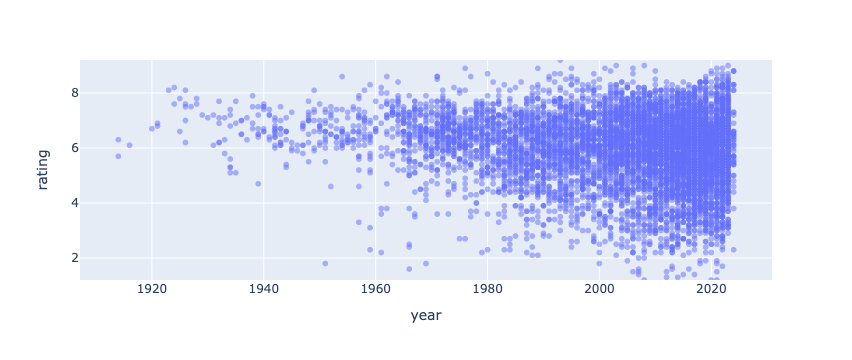

In [52]:
import plotly.express as px
px.scatter(action_movies_df, 
           x = "year", 
           y="rating", 
           opacity=0.5,
          range_y=[action_movies_df["rating"].min(), action_movies_df["rating"].max()])

Using a Common Table Expression (CTE):

In [53]:
%%sql action_grouped_df <<

WITH action_movies AS (
    SELECT 
        T.tconst AS id,
        primaryTitle AS title, 
        titleType,
        runtimeMinutes AS time,
        startYear AS year,
        genres,
        averageRating AS rating, 
        numVotes
    FROM Title T, Rating R
    WHERE 
        T.tconst = R.tconst 
        AND time > 0 AND time < 300 -- get rid of outliers and missing values --
        AND year > 0     -- get rid of missing values --
        AND titleType = 'movie' -- get movies
        AND numVotes >= 1000
    AND genres LIKE '%Action%'
)
SELECT 
    year, 
    median(rating) AS median_rating,
    quantile_cont(rating, .25) AS lower_q,
    quantile_cont(rating, .75) AS upper_q,
FROM action_movies
GROUP BY year
ORDER BY year

Running query in 'imdb'

Let's look at what we got.

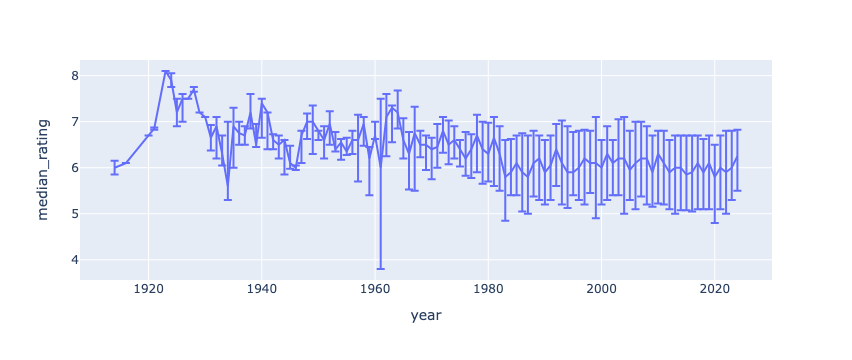

In [54]:
import plotly.express as px
action_grouped_df['error_p'] = action_grouped_df['upper_q'] - action_grouped_df['median_rating']
action_grouped_df['error_m'] = action_grouped_df['median_rating'] - action_grouped_df['lower_q'] 
fig = px.line(action_grouped_df, x="year", y="median_rating", 
              error_y="error_p", error_y_minus="error_m")
fig

### How does the runtime of an action movie influence the rating it receives?

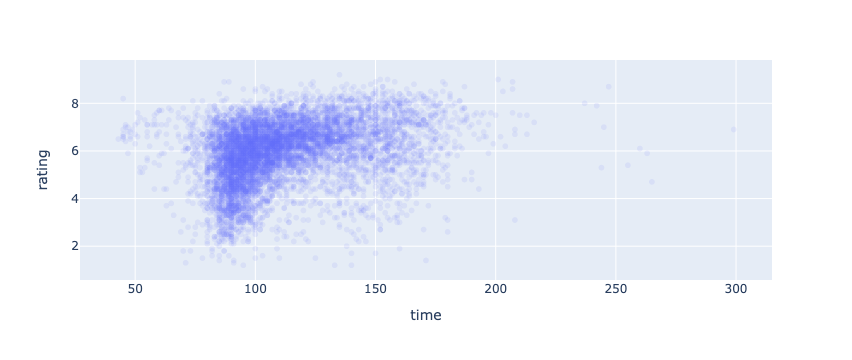

In [55]:
px.scatter(action_movies_df, x="time", y="rating", opacity=0.1)

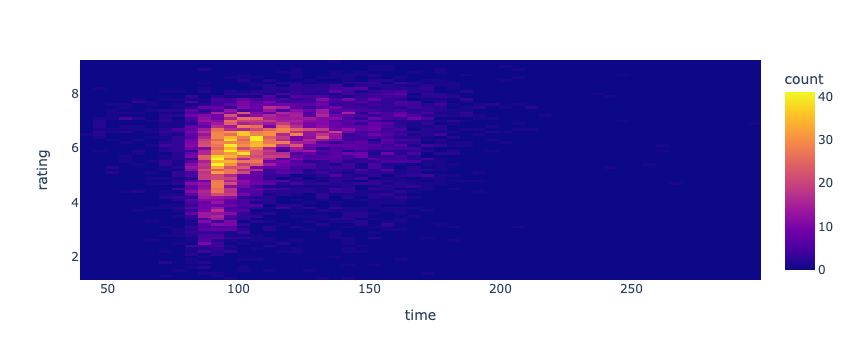

In [56]:
px.density_heatmap(action_movies_df, x="time", y="rating",nbinsx=100, nbinsy=100)

In [57]:
%%sql action_grouped_df << 
WITH action_movies AS (
    SELECT 
        T.tconst AS id,
        primaryTitle AS title, 
        titleType,
        runtimeMinutes AS time,
        startYear AS year,
        genres,
        averageRating AS rating, 
        numVotes
    FROM Title T, Rating R
    WHERE 
        T.tconst = R.tconst 
        AND time > 0 AND time < 300 -- get rid of outliers and missing values --
        AND year > 0     -- get rid of missing values --
        AND titleType = 'movie' -- get movies
        AND numVotes >= 1000
    AND genres LIKE '%Action%'
)
SELECT 
    ceil(time / 10) * 10 as time_desc, 
    median(rating) AS median_rating,
    quantile_cont(rating, .25) AS lower_q,
    quantile_cont(rating, .75) AS upper_q,
FROM action_movies
GROUP BY time_desc
ORDER BY time_desc

Running query in 'imdb'

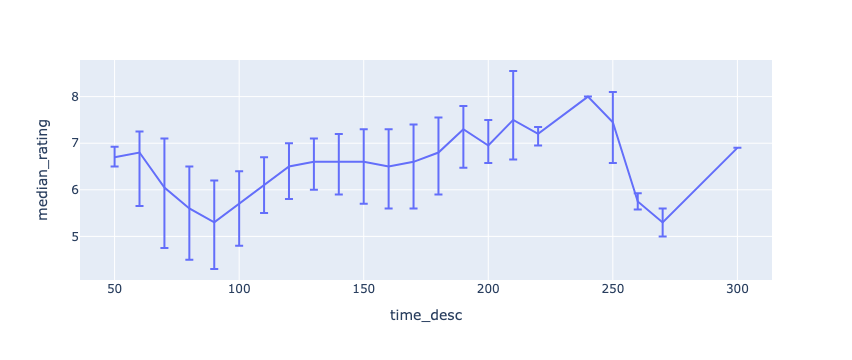

In [58]:
import plotly.express as px
action_grouped_df['error_p'] = action_grouped_df['upper_q'] - action_grouped_df['median_rating']
action_grouped_df['error_m'] = action_grouped_df['median_rating'] - action_grouped_df['lower_q'] 
fig = px.line(action_grouped_df, x="time_desc", y="median_rating", 
              error_y="error_p", error_y_minus="error_m")
fig

Could we use a movie's runtime to predict its rating?

In [59]:
import sklearn.linear_model as lm
import numpy as np
X, Y = action_movies_df["time"].to_numpy(), action_movies_df["rating"].to_numpy()

model = lm.LinearRegression()
model.fit(X[..., np.newaxis], Y)

xs = np.linspace(X.min(),X.max())
yhats = model.predict(xs[:, np.newaxis])

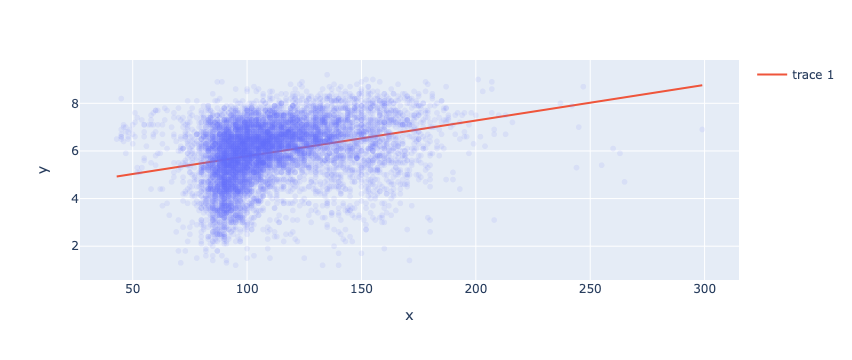

In [60]:
fig = px.scatter(x=X, y=Y, opacity=0.1)
fig.add_scatter(x=xs, y=yhats)

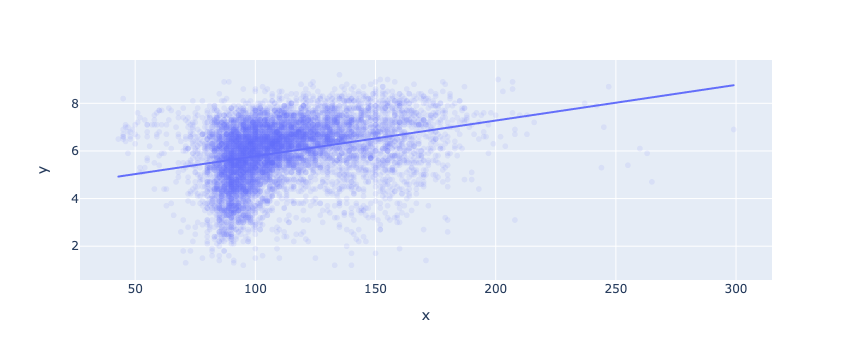

In [61]:
px.scatter(x=X, y=Y, opacity=0.1, trendline="ols")